In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm, trange
import os, sys
import pandas as pd
import seaborn as sns
sns.set(style="white")
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(0,'scripts/tools_for_VAE/')
from tools_for_VAE import model, vae_functions, utils, results_processing, plot
# import tools_for_VAE


In [2]:
%run scripts/Images_generation/cosmos_generation.py

In [10]:
images_dir = '/home/ubuntu/deblending/Deblender_VAE/images/single/'
path_output = '/home/ubuntu/deblending/Deblender_VAE/training/VAE/LSST_all/'
bands = [4,5,6,7,8,9]
r_band = 2
batch_size = 128

In [12]:
import warnings
warnings.filterwarnings("ignore")
vae, vae_utils, encoder, Dkl = utils.load_vae_conv(os.path.join(path_output, 'weights'), 6, folder=True)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 64, 64, 6)    0                                            
__________________________________________________________________________________________________
model_16 (Model)                [(None, 32), (None,  2545880     input_15[0][0]                   
__________________________________________________________________________________________________
sample_multivariate_gaussian_4  [(None, 32), (None,) 0           model_16[1][0]                   
                                                                 model_16[1][1]                   
__________________________________________________________________________________________________
model_17 (Model)                (None, 64, 64, 6)    3319942     sample_multivariate_gaussian_4[0]
Total para

In [7]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

list_of_samples_test = [x for x in listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('images.npy')]

In [ ]:
def load_test_data(samples, bands):
    galaxies = []
    dfs = []
    for sample in tqdm(samples):
        galaxies.append(np.load(sample, mmap_mode='c')[:,:,bands])
        dfs.append(pd.read_csv(sample.replace('images.npy', 'data.csv')))
    return np.concatenate(galaxies), pd.concat(dfs, ignore_index=True)

gal_data, df = load_test_data(list_of_samples_test, bands)

galaxies = {}
galaxies[('denorm','in')] = gal_data[:,1]
galaxies[('denorm','target')] = gal_data[:,0]
galaxies[('norm','in')] = utils.norm(galaxies[('denorm','in')], bands, inplace=False)
galaxies[('norm','target')] = utils.norm(galaxies[('denorm','target')], bands, inplace=False)

N_test = len(galaxies[('denorm','in')])

In [ ]:
galaxies[('norm','output')] = vae.predict(galaxies[('norm','in')].transpose([0,2,3,1])).transpose([0,3,1,2])
galaxies[('denorm','output')] = utils.denorm(galaxies[('norm','output')], bands, inplace=False)

In [ ]:
for key in galaxies.keys():
    print(key, galaxies[key].shape)

In [ ]:
df.head()

In [ ]:
N = 10

for i in range(N):
    fig, axes = plt.subplots(1,6,figsize=(6*4,1*4))
    for j in range(2):
        idx = np.random.choice(range(len(galaxies[('denorm','in')])))
        for k, key in enumerate(['in','target','output']):
            ax = axes[j*3+k]
            plot.plot_rgb(galaxies[('norm',key)][idx], bands=[1,2,3], ax=ax, shifts=None)

In [ ]:
len(PSF)

In [13]:
fluxes_in = np.sum(galaxies['denorm','target'], axis=(2,3))
fluxes_out = np.sum(galaxies['denorm','output'], axis=(2,3))

e_in = []
e_out = []

i = 6
psf_image = PSF[i].drawImage(nx=max_stamp_size, ny=max_stamp_size, scale=pixel_scale[i])

for i in trange(N_test):
#     try:
#             res_in = galsim.hsm.EstimateShear(galsim.Image(test_y[i][:,:,r_band]), psf_image)
#             res_out = galsim.hsm.EstimateShear(galsim.Image(test_output[i][:,:,r_band]), psf_image)
    res_in = galsim.hsm.EstimateShear(galsim.Image(galaxies['denorm','target'][i,r_band]), psf_image)
    res_out = galsim.hsm.EstimateShear(galsim.Image(galaxies['denorm','output'][i,r_band]), psf_image)
    if res_in.error_message != "" or res_in.error_message != "":
        print(res_in.error_message, res_out.error_message)
        e_in.append([np.nan, np.nan])
        e_out.append([np.nan, np.nan])
    else:
        e_in.append([res_in.corrected_e1, res_in.corrected_e2])
        e_out.append([res_out.corrected_e1, res_out.corrected_e2])

#     except:
#         print('error')
#         e_out.append([np.nan, np.nan])
e_in = np.array(e_in)
e_out = np.array(e_out)
# e = np.hstack([e_in,e_out])
# df = pd.DataFrame(data=np.hstack([np.hstack([e_in,e_out]), flux_in[:,None], flux_out[:,None]]), columns=['e1_in','e2_in','e1_out','e2_out', 'flux_in', 'flux_out'])

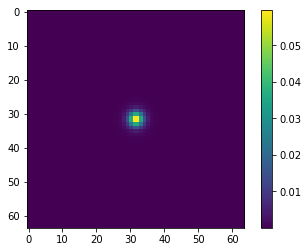

In [42]:
plt.imshow(psf_image.array)
plt.colorbar()

In [14]:
filter_names = 'ugrizy'
df['e1_in'] = e_in[:,0]
df['e2_in'] = e_in[:,1]
df['e1_out'] = e_out[:,0]
df['e2_out'] = e_out[:,1]
for i,f in enumerate(filter_names):
    df['flux_in_'+f] = fluxes_in[:,i]
    df['flux_out_'+f] = fluxes_out[:,i]

In [15]:
df.head()

,redshift,moment_sigma,e1,e2,SNR,SNR_peak,e1_in,e2_in,e1_out,e2_out,...,flux_in_g,flux_out_g,flux_in_r,flux_out_r,flux_in_i,flux_out_i,flux_in_z,flux_out_z,flux_in_y,flux_out_y
0,0.8897,1.785124,0.438782,0.127792,72.394268,0.121237,0.438782,0.127792,0.321181,0.124005,...,20182.269095,24975.705078,121616.332513,116676.406250,258237.817468,275357.593750,458849.859420,394538.687500,286628.498230,259055.734375
1,0.5511,1.830960,-0.601029,0.651748,56.757283,0.092024,-0.601029,0.651748,-0.607325,0.595814,...,34738.713456,34036.347656,81030.752495,68222.390625,115398.641960,102801.117188,103019.539343,107969.945312,57496.852828,62198.101562
2,1.0860,2.428643,-0.109793,-0.412433,15.629682,0.020036,-0.109793,-0.412433,-0.277855,-0.598696,...,21051.992885,21261.494141,32375.269873,42145.343750,57695.445007,63766.386719,78277.737608,71883.953125,50463.503286,44679.769531
3,0.9549,1.767379,-0.521411,-0.132440,23.103399,0.037087,-0.521411,-0.132440,-0.557070,-0.122451,...,21756.369346,25381.160156,30550.760175,38973.140625,44966.241242,46723.957031,49567.168361,45621.972656,28789.913060,26831.302734
4,3.3189,1.636836,0.118800,0.593665,12.848950,0.022244,0.118800,0.593665,0.033103,0.043583,...,17041.119546,14781.580078,16985.227173,16557.250000,16044.738962,16271.858398,18010.358647,15814.428711,10962.899206,10504.396484


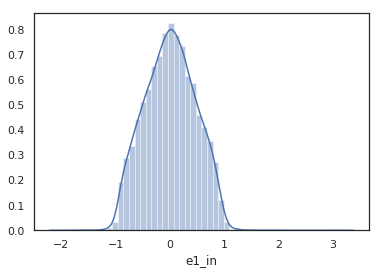

In [70]:
sns.distplot(df['e1_in'])

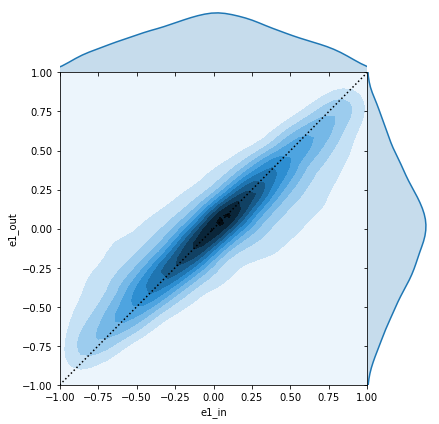

In [37]:
ax = sns.jointplot('e1_in', 'e1_out', df, kind='kde', space=0.)
ax.ax_joint.set_xlim(-1,1)
ax.ax_joint.set_ylim(-1,1)
ax.ax_joint.plot([-1,1],[-1,1], ':k')

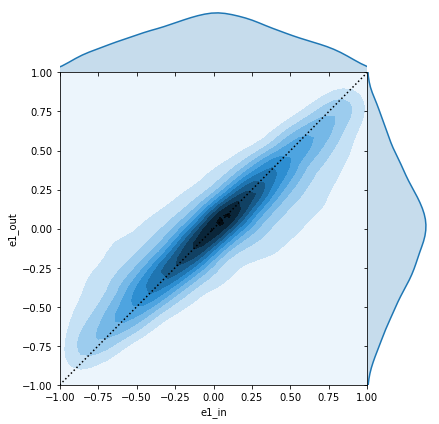

In [17]:
ax = sns.jointplot('e2_in', 'e2_out', df.dropna(), kind='kde', space=0.)
ax.ax_joint.set_xlim(-1,1)
ax.ax_joint.set_ylim(-1,1)
ax.ax_joint.plot([-1,1],[-1,1], ':k')

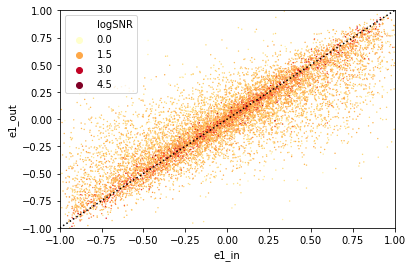

In [32]:
df['logSNR'] = np.log10(df['SNR'])
ax = sns.scatterplot('e1_in', 'e1_out', data=df.dropna(), hue='logSNR', s=2, linewidth=0, palette="YlOrRd")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.plot([-1,1],[-1,1], ':k')

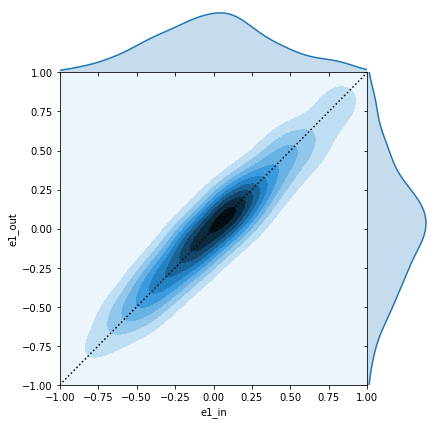

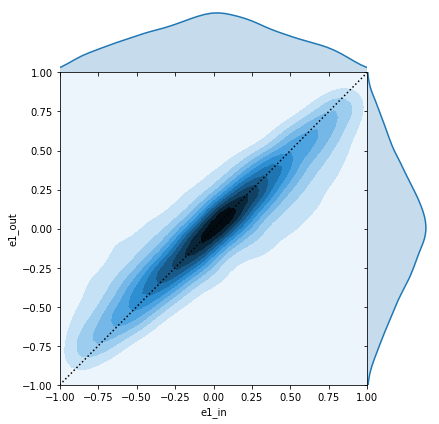

In [36]:
ax = sns.jointplot('e1_in', 'e1_out', df[df['SNR']>150.].dropna(), kind='kde', space=0.)
ax.ax_joint.set_xlim(-1,1)
ax.ax_joint.set_ylim(-1,1)
ax.ax_joint.plot([-1,1],[-1,1], ':k')

ax = sns.jointplot('e1_in', 'e1_out', df[df['SNR']>10.].dropna(), kind='kde', space=0.)
ax.ax_joint.set_xlim(-1,1)
ax.ax_joint.set_ylim(-1,1)
ax.ax_joint.plot([-1,1],[-1,1], ':k')

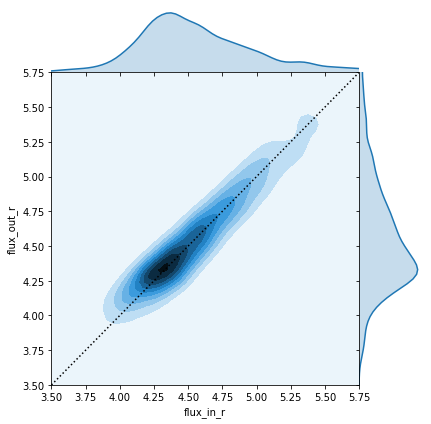

In [60]:
ax = sns.jointplot(np.log10(df['flux_in_r']), np.log10(df['flux_out_r']), kind='kde', space=0.,)
#                    joint_kws={'hue':'logSNR', 's':2, 'linewidth':0, 'palette':"YlOrRd"})
#                    joint_kws={'scatter_kws':{'hue':'logSNR', 's':2, 'linewidth':0, 'palette':"YlOrRd"}})
xmin = 3.5
xmax = 5.75
ax.ax_joint.set_xlim(xmin,xmax)
ax.ax_joint.set_ylim(xmin,xmax)
ax.ax_joint.plot([xmin,xmax],[xmin,xmax], ':k')

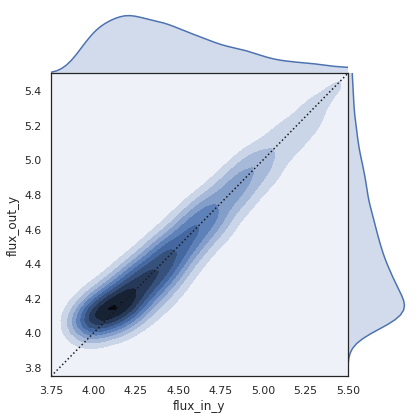

In [66]:
ax = sns.jointplot(np.log10(df['flux_in_y']), np.log10(df['flux_out_y']), kind='kde', space=0.,)
#                    joint_kws={'hue':'logSNR', 's':2, 'linewidth':0, 'palette':"YlOrRd"})
#                    joint_kws={'scatter_kws':{'hue':'logSNR', 's':2, 'linewidth':0, 'palette':"YlOrRd"}})
xmin = 3.75
xmax = 5.5
ax.ax_joint.set_xlim(xmin,xmax)
ax.ax_joint.set_ylim(xmin,xmax)
ax.ax_joint.plot([xmin,xmax],[xmin,xmax], ':k')

In [77]:
sys.path.insert(0, 'scripts/VAE')
from generator_vae import BatchGenerator
test_generator = BatchGenerator(bands, list_of_samples_test, total_sample_size=None,
                                    batch_size=batch_size, size_of_lists=None,
                                    scale_radius=None, SNR=None,
                                    trainval_or_test='test',
                                    noisy=True, do_norm=True)#180000

[BatchGenerator] total_sample_size =  20100
[BatchGenerator] len(list_of_samples) =  21


In [78]:
# results_processing.VAE_processing(vae, test_generator, bands, 2, 64, 3, batch_size, PSF_lsst, pixel_scale_lsst)

In [79]:
test_x, test_y = test_generator.__getitem__(0)
test_output = vae.predict(test_y)

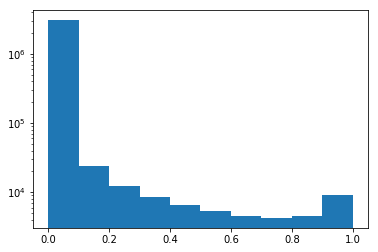

In [80]:
_ = plt.hist(test_output.ravel(), log=True)

In [98]:
galaxies = np.array([test_x,test_y,test_output]).transpose([1,0,4,2,3])

In [99]:
galaxies.shape

(128, 3, 6, 64, 64)

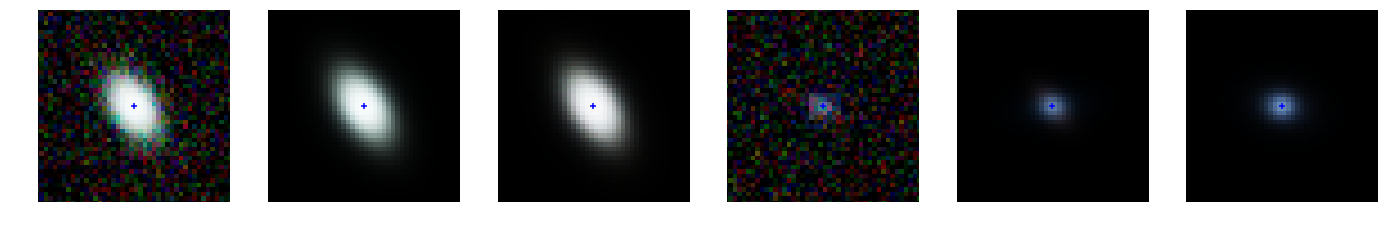

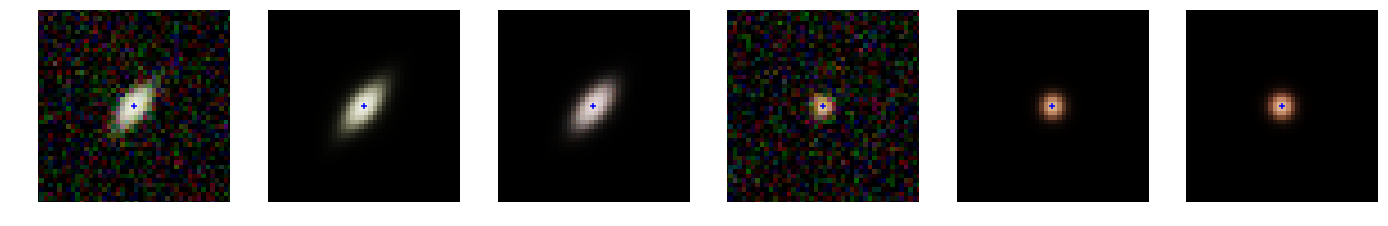

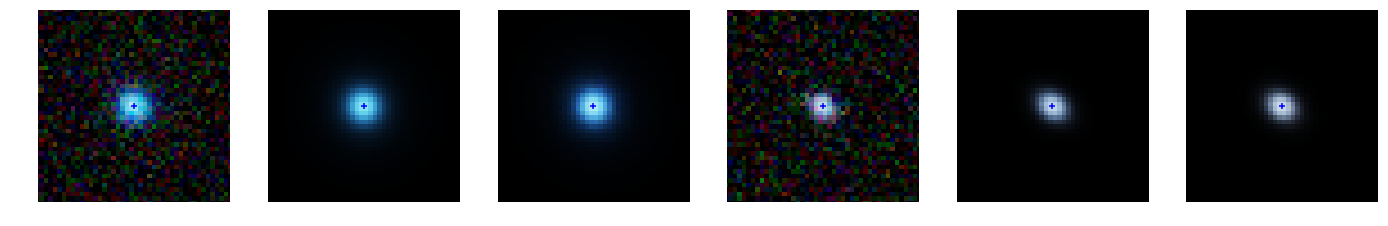

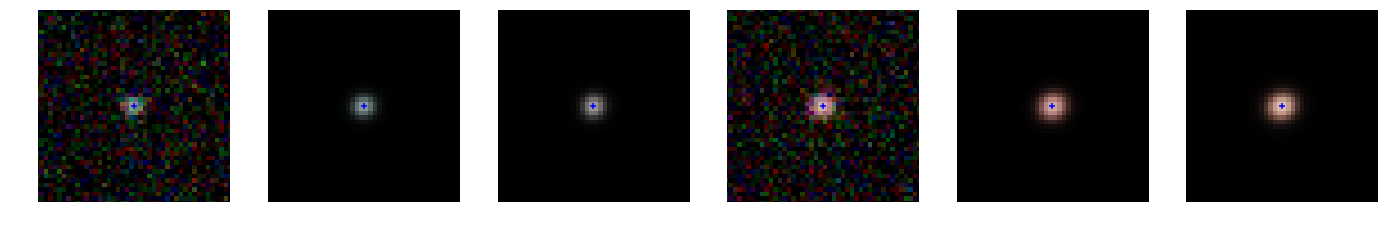

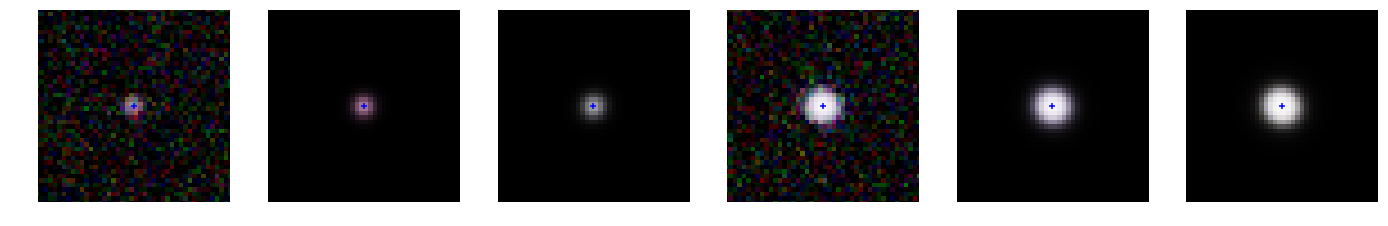

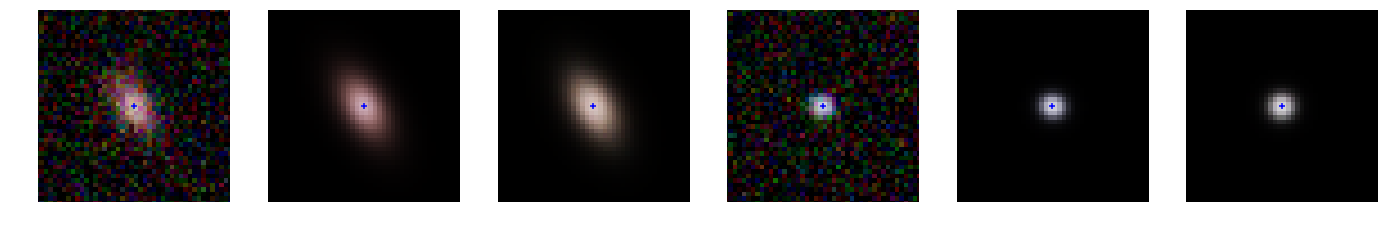

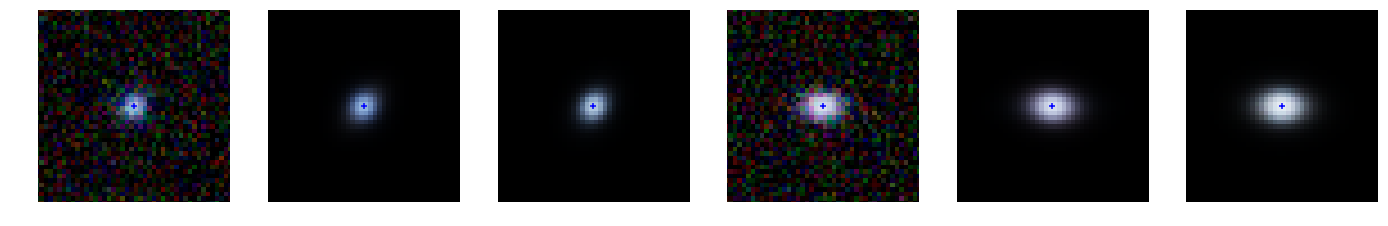

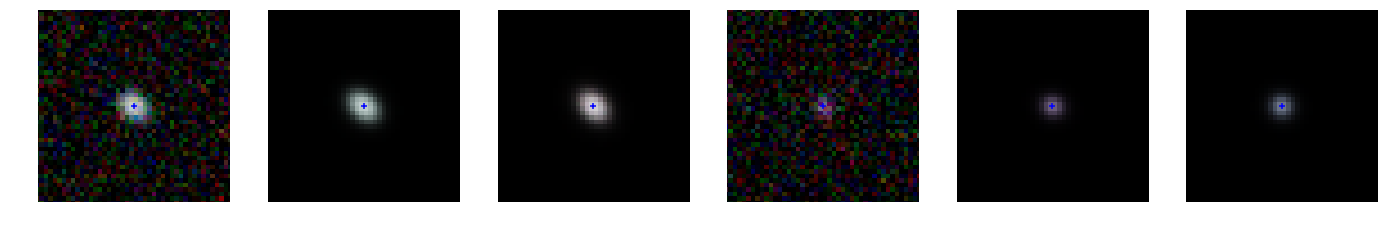

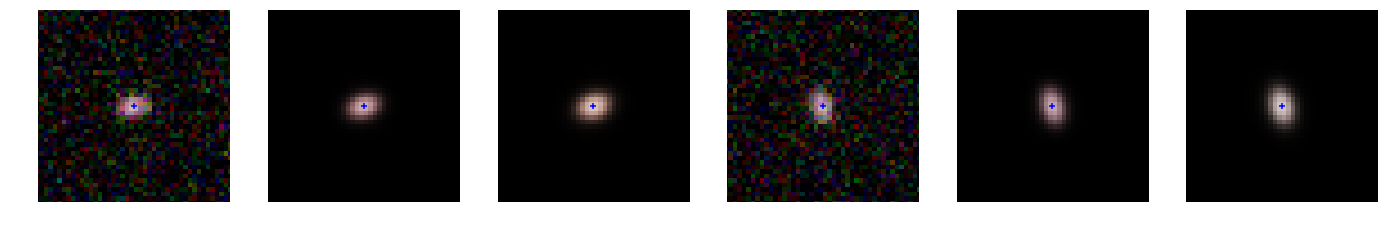

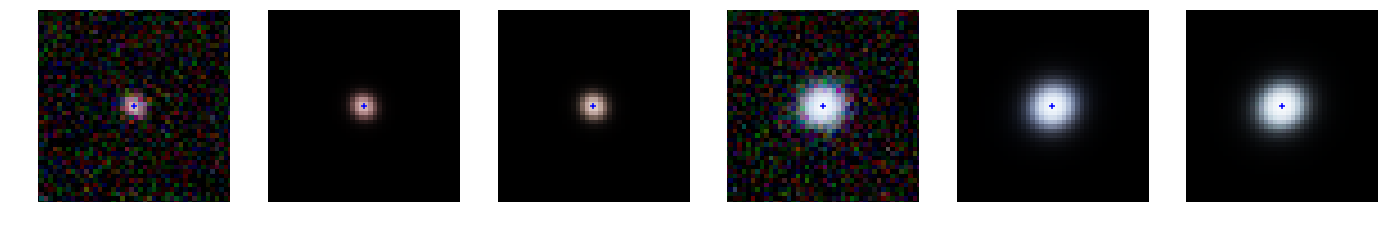

In [101]:
N = 10

for i in range(N):
    fig, axes = plt.subplots(1,6, figsize=(6*4,1*4))
    for j in range(2):
        idx = np.random.choice(range(len(galaxies)))
        for k in range(3):
            ax = axes[j*3+k]
            plot_rgb(galaxies[idx][k], bands=[1,2,3], ax=ax, shifts=None)
#             ax.set_title(str(int(np.sum(shifts[idx]!=0.)/2)))

In [102]:
test_x = utils.denorm(test_x, bands, channel_last=True)
test_y = utils.denorm(test_y, bands, channel_last=True)
test_output = utils.denorm(test_output, bands, channel_last=True)

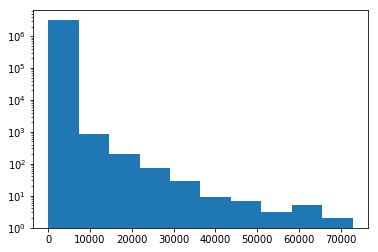

In [57]:
_ = plt.hist(test_output.ravel(), log=True)

In [103]:
i = 6
psf_image = PSF[i].drawImage(nx=max_stamp_size, ny=max_stamp_size, scale=pixel_scale[i])

In [139]:
e_in = []
e_out = []
flux_in = []
flux_out = []
for _ in trange(3):
    test_x, test_y = test_generator.__getitem__(0)
    test_output = vae.predict(test_y)
#     test_x = utils.denorm(test_x, bands, channel_last=True)
    test_y = utils.denorm(test_y, bands, channel_last=True)
    test_output = utils.denorm(test_output, bands, channel_last=True)
    for i in range(len(test_x)):
        flux_in.append(np.sum(test_y[i][:,:,r_band]))
        flux_out.append(np.sum(test_output[i][:,:,r_band]))
        try:
            res_in = galsim.hsm.EstimateShear(galsim.Image(test_y[i][:,:,r_band]), psf_image)
            res_out = galsim.hsm.EstimateShear(galsim.Image(test_output[i][:,:,r_band]), psf_image)
            if res_in.error_message != "":
                e_in.append([np.nan, np.nan])
                e_out.append([np.nan, np.nan])
            else:
                e_in.append([res_in.corrected_e1, res_in.corrected_e2])
                e_out.append([res_out.corrected_e1, res_out.corrected_e2])
        except:
            e_in.append([np.nan, np.nan])
            e_out.append([np.nan, np.nan])
e_in = np.array(e_in)
e_out = np.array(e_out)
flux_in = np.array(flux_in)
flux_out = np.array(flux_out)
e = np.hstack([e_in,e_out])
df = pd.DataFrame(data=np.hstack([np.hstack([e_in,e_out]), flux_in[:,None], flux_out[:,None]]), columns=['e1_in','e2_in','e1_out','e2_out', 'flux_in', 'flux_out'])

In [140]:
df.head()

,e1_in,e2_in,e1_out,e2_out,flux_in,flux_out
0,-0.041555,0.491489,-0.056654,0.288564,63640.107280,89404.367188
1,0.056249,-0.610341,0.062503,-0.527029,107423.356012,141921.968750
2,-0.311809,0.484984,-0.229477,0.139547,20322.933785,17718.394531
3,-0.109733,-0.593487,-0.105052,-0.527570,43970.384597,49542.125000
4,0.619238,0.437016,-0.059377,0.176280,19561.558921,17581.226562


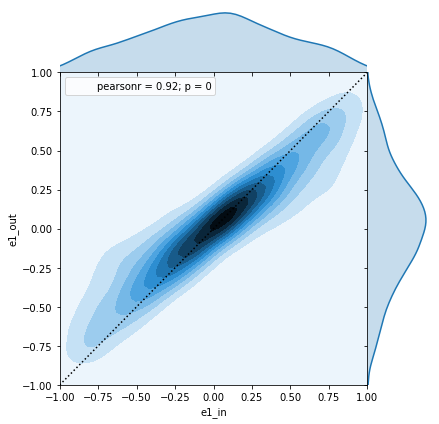

In [120]:

ax = sns.jointplot('e1_in', 'e1_out', df.dropna(), kind='kde', space=0.)
ax.ax_joint.set_xlim(-1,1)
ax.ax_joint.set_ylim(-1,1)
ax.ax_joint.plot([-1,1],[-1,1], ':k')

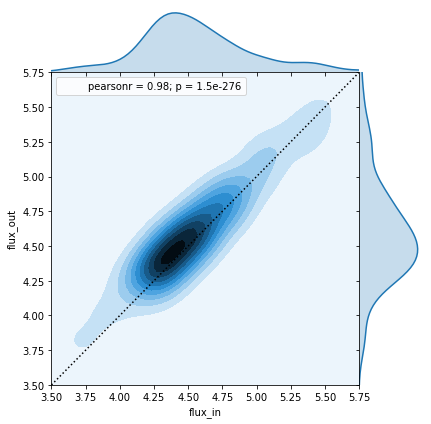

In [147]:
import warnings
warnings.filterwarnings("ignore")
ax = sns.jointplot(np.log10(df['flux_in']), np.log10(df['flux_out']), kind='kde', space=0.)
xmin = 3.5
xmax = 5.75
ax.ax_joint.set_xlim(xmin,xmax)
ax.ax_joint.set_ylim(xmin,xmax)
ax.ax_joint.plot([xmin,xmax],[xmin,xmax], ':k')
# ax.ax_joint.set_xscale('log')
# ax.ax_joint.set_yscale('log')

In [151]:
df.loc[[2,3]]

,e1_in,e2_in,e1_out,e2_out,flux_in,flux_out
2,-0.311809,0.484984,-0.229477,0.139547,20322.933785,17718.394531
3,-0.109733,-0.593487,-0.105052,-0.527570,43970.384597,49542.125000


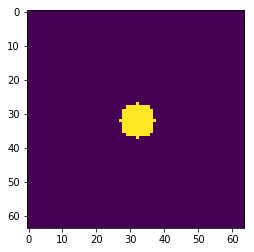

In [45]:
plt.imshow(plot.createCircularMask(64,64,None,5))